<a href="https://colab.research.google.com/github/fraco03/6D_pose/blob/pose_rgb/notebooks/pose_rgb/pose_rbg_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import os
import sys

# Clone or pull part
repo_url = "https://github.com/fraco03/6D_pose.git"
repo_dir = "/content/6D_pose"   #Modify here for kaggle
branch = "pose_rgb" # Modify branch here

# Clone if missing
if not os.path.exists(repo_dir):
    !git clone -b {branch} {repo_url}
    print(f"Cloned {repo_url} to {repo_dir}")
else:
    %cd {repo_dir}
    !git fetch origin
    !git checkout {branch}
    !git reset --hard origin/{branch}
    %cd ..
    print(f"Updated {repo_url} to {repo_dir}")

# Add repository to Python path
if repo_dir not in sys.path:
    sys.path.insert(0, repo_dir)


/content/6D_pose
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 17 (delta 10), reused 17 (delta 10), pack-reused 0 (from 0)
Unpacking objects: 100% (17/17), 7.73 KiB | 53.00 KiB/s, done.
From https://github.com/fraco03/6D_pose
   ba60117..3ce9993  main       -> origin/main
Already on 'pose_rgb'
Your branch is up to date with 'origin/pose_rgb'.
HEAD is now at 5d4cd70 Update: loss and model for pose_rgb
/content
Updated https://github.com/fraco03/6D_pose.git to /content/6D_pose


In [2]:
%cd 6D_pose

/content/6D_pose


In [3]:
from google.colab import drive
from utils.load_data import mount_drive

# Mounting part
mount_drive()

dataset_root = "/content/drive/MyDrive/Linemod_preprocessed" #Modify here for kaggle

print("\n✅ Setup complete!")
print(f"📁 Dataset path: {dataset_root}")


Mounted at /content/drive
✅ Drive mounted at /content/drive

✅ Setup complete!
📁 Dataset path: /content/drive/MyDrive/Linemod_preprocessed


In [4]:
from src.pose_rgb.dataset import LineModPoseDataset
from src.pose_rgb.model import ResNetRotation, TranslationNet
from src.pose_rgb.pose_utils import quaternion_to_rotation_matrix, convert_rotation_to_quaternion, inverse_pinhole_projection
from src.pose_rgb.test_dataset import *
from src.pose_rgb.loss import AutomaticWeightedLoss
from torch.utils.data import Dataset, DataLoader
import pathlib
import torch.optim as optim
from tqdm import tqdm


In [5]:
root_dir = '/content/drive/MyDrive/Linemod_preprocessed' #Modify here for kaggle
# root_dir = "../../Linemod_preprocessed_smaller"  #Modify here for local

train_dataset = LineModPoseDataset(split='train', root_dir=root_dir)
test_dataset = LineModPoseDataset(split='test', root_dir=root_dir)



 Loaded LineModPoseDataset
   Split: train
   Dir : [1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15]
   Total samples: 3631
 Loaded LineModPoseDataset
   Split: test
   Dir : [1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15]
   Total samples: 20528


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [9]:
#Dataloder
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

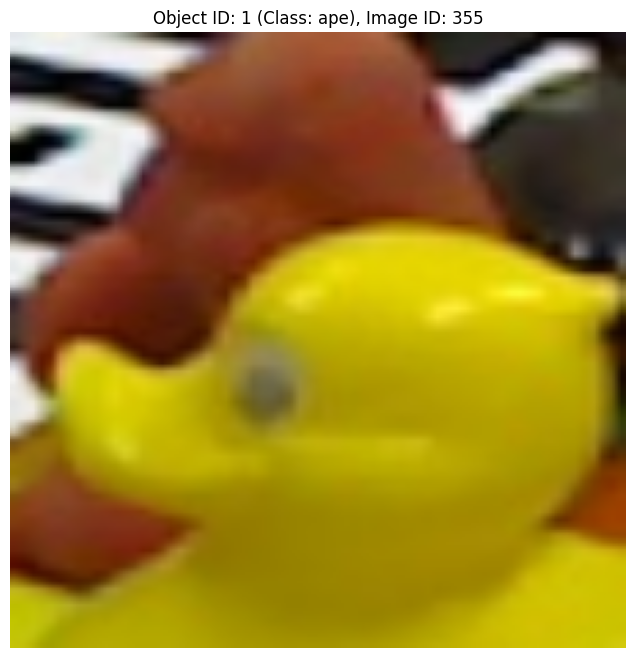


--- Posa 6D per Campione Casuale (ID Oggetto: 1) ---
  Rotazione (Quaternione w,x,y,z): [ 0.17280701  0.14115073  0.76838136 -0.5998369 ]
  Traslazione (mm) (tx,ty,tz): [-0.19581424 -0.00943179  0.6659477 ]
  Classe Oggetto: ape


In [6]:
import matplotlib.pyplot as plt
import random
import torch
import numpy as np

def display_random_sample_with_pose(dataset):
    """
    Prende un campione casuale dal dataset, visualizza l'immagine
    e stampa le informazioni sulla posa 6D (rotazione e traslazione).

    Args:
        dataset: L'istanza del LineModPoseDataset da cui estrarre il campione.
    """
    # Scegli un indice casuale
    idx = random.randint(0, len(dataset) - 1)
    sample = dataset[idx]

    # Estrai i dati dal campione
    img_tensor = sample['image']
    rotation_quat = sample['rotation'].numpy() # Quaternion (w, x, y, z)
    translation_vec = sample['translation'].numpy() # Translation (tx, ty, tz)
    object_id = sample['object_id']
    class_idx = sample['class_idx']
    img_id = sample['img_id']

    # Denormalizza l'immagine per la visualizzazione
    # I valori di mean e std sono quelli usati per la normalizzazione di ImageNet
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    denormalized_img = img_tensor * std + mean

    # Converti in numpy e riorganizza le dimensioni da (C, H, W) a (H, W, C) per matplotlib
    img_np = denormalized_img.permute(1, 2, 0).numpy()

    # Assicurati che i valori siano nel range [0, 1] per la visualizzazione
    img_np = np.clip(img_np, 0, 1)

    # Visualizza l'immagine
    plt.figure(figsize=(8, 8))
    plt.imshow(img_np)
    plt.title(f"Object ID: {object_id} (Class: {class_idx}), Image ID: {img_id}")
    plt.axis('off')
    plt.show()

    # Stampa le informazioni sulla posa
    print(f"\n--- Posa 6D per Campione Casuale (ID Oggetto: {object_id}) ---")
    print(f"  Rotazione (Quaternione w,x,y,z): {rotation_quat}")
    print(f"  Traslazione (mm) (tx,ty,tz): {translation_vec}")
    print(f"  Classe Oggetto: {class_idx}")

# Esempio di utilizzo della funzione con il train_dataset
display_random_sample_with_pose(train_dataset)

In [ ]:
import os
import torch
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import json
from datetime import datetime
from itertools import islice

# ==========================================
# 1. SETUP & HYPERPARAMETERS
# ==========================================
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LEARNING_RATE = 1e-4
NUM_EPOCHS = 50

# Creiamo una cartella specifica per questo run usando il timestamp
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
CHECKPOINT_DIR = f'/content/drive/MyDrive/runs/{timestamp}' # modify here for kaggle
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Assegno run_dir per compatibilità col tuo codice di plot
run_dir = CHECKPOINT_DIR

# Initialize Models
model_rot = ResNetRotation(freeze_backbone=True).to(DEVICE)
model_trans = TranslationNet().to(DEVICE)

# Initialize Loss & Optimizer
# Assicurati che AutomaticWeightedLoss e le sue sottoclassi siano definite prima di qui
criterion = AutomaticWeightedLoss().to(DEVICE)

optimizer = torch.optim.Adam(
    list(model_rot.parameters()) + list(model_trans.parameters()) + list(criterion.parameters()),
    lr=LEARNING_RATE
)

train_losses = []
val_losses = []

best_val_loss = float('inf')
best_epoch = 0

print(f"\n🔥 STARTING TRAINING on {DEVICE}...")
print(f"📁 Saving outputs to: {run_dir}")

# ==========================================
# 2. TRAINING LOOP
# ==========================================
for epoch in range(NUM_EPOCHS):

    # --- A. TRAIN PHASE ---
    model_rot.train()
    model_trans.train()

    running_train_loss = 0.0

    # Progress Bar for Training
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]")

    for batch in pbar:
        # Move data to GPU
        imgs = batch['image'].to(DEVICE)
        bbox_info = batch['bbox_info'].to(DEVICE)
        gt_rot = batch['rotation'].to(DEVICE)
        gt_trans_abs = batch['translation'].to(DEVICE)  # [X, Y, Z] in METRI
        cam_K = batch['cam_K'].to(DEVICE)  # Camera intrinsics in MILLIMETRI
        bbox_centers = batch['bbox_center'].to(DEVICE)

        # 1. Forward
        pred_rot = model_rot(imgs)
        pred_trans = model_trans(imgs, bbox_info)

        # 2. Conversione predizioni
        # Il modello predice [dx, dy, log(z)] dove dx,dy sono pixel offset e z è in metri
        pred_dx_dy = pred_trans[:, :2]  # Pixel offsets
        pred_z_log = pred_trans[:, 2]   # Log(Z_meters)

        # Converti da log a metri
        pred_z_m = torch.exp(pred_z_log)

        # 3. Geometria (Pinhole Projection)
        # cam_K è in mm, quindi devo convertire z da metri a mm
        pred_z_mm = pred_z_m * 1000.0
        
        # Calcoliamo X e Y in mm usando la pinhole projection
        pred_3d_mm = inverse_pinhole_projection(
            crop_center=bbox_centers,
            deltas=pred_dx_dy,
            z=pred_z_mm,  # Z in mm per compatibilità con cam_K
            cam_K=cam_K
        )
        # pred_3d_mm ora è [X_mm, Y_mm, Z_mm]
        
        # Converti tutto in metri per la loss
        pred_3d_m = pred_3d_mm / 1000.0

        # 4. Loss (tutto in metri)
        loss, l_r, l_xy, l_z = criterion(pred_rot, gt_rot, pred_3d_m, gt_trans_abs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

        # Logging utile nella progress bar
        pbar.set_postfix({
            'L_Tot': f"{loss.item():.2f}",
            'L_Rot': f"{l_r.item():.2f}",
            'L_XY': f"{l_xy.item():.3f}",
            'L_Z': f"{l_z.item():.3f}"
        })


    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # --- B. EVALUATION PHASE ---
    model_rot.eval()
    model_trans.eval()

    running_val_loss = 0.0
    val_batches_limit = 50  # <--- too sample in the validation, take a subpart
    count_batches = 0

    with torch.no_grad():

        val_iterator = islice(test_loader, val_batches_limit)
        val_pbar = tqdm(val_iterator, total=val_batches_limit, desc="Validating")

        for batch in val_pbar:
            imgs = batch['image'].to(DEVICE)
            bbox_info = batch['bbox_info'].to(DEVICE)
            gt_rot = batch['rotation'].to(DEVICE)
            gt_trans_abs = batch['translation'].to(DEVICE)  # [X, Y, Z] in METRI
            cam_K = batch['cam_K'].to(DEVICE)  # in MILLIMETRI
            bbox_centers = batch['bbox_center'].to(DEVICE)

            # 1. Forward
            pred_rot = model_rot(imgs)
            pred_trans = model_trans(imgs, bbox_info)

            # 2. Conversione predizioni
            pred_dx_dy = pred_trans[:, :2]
            pred_z_log = pred_trans[:, 2]
            pred_z_m = torch.exp(pred_z_log)
            
            # 3. Geometria: converte z in mm per la pinhole projection
            pred_z_mm = pred_z_m * 1000.0
            pred_3d_mm = inverse_pinhole_projection(
                crop_center=bbox_centers,
                deltas=pred_dx_dy,
                z=pred_z_mm,
                cam_K=cam_K
            )
            
            # Converti tutto in metri per la loss
            pred_3d_m = pred_3d_mm / 1000.0

            # 4. Loss (tutto in metri)
            loss, _, _, _ = criterion(pred_rot, gt_rot, pred_3d_m, gt_trans_abs)
            running_val_loss += loss.item()

            count_batches += 1

    # Evitiamo division by zero se il loader è vuoto
    if count_batches > 0:
        avg_val_loss = running_val_loss / count_batches
    else:
        avg_val_loss = 0.0

    val_losses.append(avg_val_loss)

    # --- C. REPORT & SAVE ---
    print(f"📊 Epoch {epoch+1} Summary: Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # Save Best Model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = epoch + 1

        save_path = os.path.join(CHECKPOINT_DIR, "best_model.pth")
        torch.save({
            'epoch': epoch,
            'model_rot': model_rot.state_dict(),
            'model_trans': model_trans.state_dict(),
            'criterion': criterion.state_dict(), # Salviamo anche i pesi della loss (sx, sy, sz)
            'val_loss': best_val_loss
        }, save_path)
        print(f"🏆 New Best Model Saved! (Loss: {best_val_loss:.4f})")

    # Save Last Checkpoint
    if (epoch + 1) == NUM_EPOCHS:
        torch.save({
            'epoch': epoch+1,
            'model_rot': model_rot.state_dict(),
            'model_trans': model_trans.state_dict(),
            'criterion': criterion.state_dict(),
        }, os.path.join(CHECKPOINT_DIR, f"checkpoint_ep{epoch+1}.pth"))

print("\n🎉 TRAINING COMPLETE! Generating plots...")

🔒 ResNet backbone frozen.

🔥 STARTING TRAINING on cuda...
📁 Saving outputs to: /content/drive/MyDrive/runs/20251216_120636


Validating: 100%|██████████| 50/50 [02:18<00:00,  2.78s/it]


📊 Epoch 1 Summary: Train Loss: 0.4078 | Val Loss: 0.2664
🏆 New Best Model Saved! (Loss: 0.2664)


Validating: 100%|██████████| 50/50 [00:31<00:00,  1.57it/s]


📊 Epoch 2 Summary: Train Loss: 0.2683 | Val Loss: 0.1981
🏆 New Best Model Saved! (Loss: 0.1981)


Validating: 100%|██████████| 50/50 [00:31<00:00,  1.57it/s]


📊 Epoch 3 Summary: Train Loss: 0.1942 | Val Loss: 0.1566
🏆 New Best Model Saved! (Loss: 0.1566)


Validating: 100%|██████████| 50/50 [00:31<00:00,  1.58it/s]


📊 Epoch 4 Summary: Train Loss: 0.1212 | Val Loss: 0.0983
🏆 New Best Model Saved! (Loss: 0.0983)


Validating: 100%|██████████| 50/50 [00:31<00:00,  1.57it/s]


📊 Epoch 5 Summary: Train Loss: 0.0652 | Val Loss: 0.0525
🏆 New Best Model Saved! (Loss: 0.0525)


Validating: 100%|██████████| 50/50 [00:32<00:00,  1.52it/s]


📊 Epoch 6 Summary: Train Loss: 0.0090 | Val Loss: 0.0137
🏆 New Best Model Saved! (Loss: 0.0137)


Validating: 100%|██████████| 50/50 [00:32<00:00,  1.56it/s]


📊 Epoch 7 Summary: Train Loss: -0.0401 | Val Loss: -0.0264
🏆 New Best Model Saved! (Loss: -0.0264)


Validating: 100%|██████████| 50/50 [00:33<00:00,  1.48it/s]


📊 Epoch 8 Summary: Train Loss: -0.0866 | Val Loss: -0.0776
🏆 New Best Model Saved! (Loss: -0.0776)


Epoch 9/50 [Train]:   5%|▌         | 6/114 [00:04<01:18,  1.37it/s, L_Tot=-0.13, L_Rot=0.13, L_XY=0.0, L_Z=0.01]


KeyboardInterrupt: 

In [ ]:
# Plot training history
plt.figure(figsize=(12, 6))

# Grafico Lineare
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o', alpha=0.7)
plt.plot(val_losses, label='Validation Loss', marker='s', alpha=0.7)
# best_epoch-1 perchè i plot partono da indice 0, ma l'epoca è 1-based
if best_epoch > 0:
    plt.axvline(x=best_epoch-1, color='r', linestyle='--', alpha=0.5, label=f'Best Epoch ({best_epoch})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Grafico Logaritmico (Utile se la loss scende molto)
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss', marker='o', alpha=0.7)
plt.plot(val_losses, label='Validation Loss', marker='s', alpha=0.7)
if best_epoch > 0:
    plt.axvline(x=best_epoch-1, color='r', linestyle='--', alpha=0.5, label=f'Best Epoch ({best_epoch})')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.yscale('log')
plt.title('Training and Validation Loss (Log Scale)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plot_path = os.path.join(run_dir, 'training_history.png')
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Training Statistics:")
print(f"   Total epochs: {len(train_losses)}")
print(f"   Best epoch: {best_epoch}")
print(f"   Best val loss: {best_val_loss:.6f}")
print(f"   Final train loss: {train_losses[-1]:.6f}")
print(f"   Final val loss: {val_losses[-1]:.6f}")

# Save training history to JSON
history = {
    'train_losses': [float(x) for x in train_losses],
    'val_losses': [float(x) for x in val_losses],
    'best_epoch': int(best_epoch),
    'best_val_loss': float(best_val_loss),
    'total_epochs': len(train_losses),
    'timestamp': timestamp
}

history_path = os.path.join(run_dir, 'training_history.json')
with open(history_path, 'w') as f:
    json.dump(history, f, indent=2)

print(f"\n💾 Training history saved to: {history_path}")
print(f"📈 Plot saved to: {plot_path}")

In [14]:
%ls

6D_pose/  drive/  sample_data/


In [15]:
%cd 6D_pose/

/content/6D_pose


In [17]:
!git status

On branch pose_rgb
Your branch is up to date with 'origin/pose_rgb'.

nothing to commit, working tree clean
